# Predicting COVID-19 cases in Ireland

## Import the Libraries

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Import the Datasets
- Data for COVID cases the Republic of Ireland was sourced from Our World in Data
- Data for the prevalence of COVID-19 internet searches were sourced from Google Trends
- Data for COVID cases in Northern Ireland was sourced from the Department of Health for Northern Ireland 

In [2]:
# Import Republic of Ireland and Google Trends data
roi_data = pd.read_excel("preparedData.xlsx")

In [3]:
# Import Northern Ireland data
#ni_data = pd.read_excel("ni_smoothed.xlsx")

In [4]:
# Merge the datasets
#data = pd.merge(roi_data, ni_data, left_on='date', right_on='date', how='left')

In [5]:
data = roi_data.copy(deep=True)

In [6]:
data.fillna(0, inplace=True)

In [7]:
#data['new_cases_smoothed'] = data['new_cases_smoothed']+data['newCasesByPublishDateSmoothed']

In [8]:
data.head(5)

,date,new_cases,new_cases_smoothed,reproduction_rate,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,...,book covid test: (Ireland)_y,covid test dublin: (Ireland),covid test centre: (Ireland),hse covid vaccine: (Ireland),hse vaccine portal: (Ireland),hse portal vaccine: (Ireland),pcr test hse: (Ireland),hse covid test: (Ireland),hse vaccine registration: (Ireland),how long will it take to vaccinate ireland: (Ireland)
0,2020-03-15,0,15.714,2.51,0,0.0,0.0,0,0,0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,2020-03-16,40,21.143,2.59,0,0.0,0.0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2020-03-17,54,27.000,2.70,0,0.0,0.0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2020-03-18,69,35.571,2.78,0,0.0,0.0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2020-03-19,265,73.429,2.84,946,0.0,0.0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', ascending=True, inplace=True)
data = data.set_index('date')

In [10]:
data.drop(columns=['tests_per_case', 'new_cases','new_tests','reproduction_rate',
                   'positive_rate','total_vaccinations','stringency_index',
            'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations','population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'life_expectancy', 'human_development_index', 
       'COVID-19 testing: (Ireland)', 'COVID-19 rapid antigen test: (Ireland)',
       'Health Service Executive: (Ireland)', 'Vaccination: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'pharmacy near me: (Ireland)',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'book covid test: (Ireland)_y', 'covid test dublin: (Ireland)',
       'covid test centre: (Ireland)', 'hse covid vaccine: (Ireland)',
       'hse vaccine portal: (Ireland)', 'hse portal vaccine: (Ireland)',
       'pcr test hse: (Ireland)', 'hse covid test: (Ireland)',
       'hse vaccine registration: (Ireland)',
       'how long will it take to vaccinate ireland: (Ireland)'],inplace=True)

In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed,702.0,1765.404761,3401.510241,6.571,286.4645,536.214,1522.107,23752.0
covid: (Ireland),702.0,29.676638,13.652692,0.000,20.2500,26.000,34.000,100.0


In [12]:
# Take a copy of dataframe without NaN values
df = data.dropna()

In [13]:
df.tail()

,new_cases_smoothed,covid: (Ireland)
date,,
2022-02-10,5281.571,16.0
2022-02-11,5270.286,16.0
2022-02-12,5270.286,16.0
2022-02-13,5270.286,16.0
2022-02-14,4927.000,0.0


In [14]:
df.loc[:,'ncs'] = df.loc[:,'new_cases_smoothed'].shift(5)
df.loc[:,'ncs_diff'] = df.loc[:,'ncs'].diff()
df.loc[:,'ncs2'] = df.loc[:,'ncs'].shift()
df.loc[:,'ncs_diff2'] = df.loc[:,'ncs2'].diff()
df.loc[:,'ncs3'] = df.loc[:,'ncs2'].shift()
df.loc[:,'ncs_diff3'] = df.loc[:,'ncs3'].diff()
df.loc[:,'ncs4'] = df.loc[:,'ncs3'].shift()
df.loc[:,'ncs_diff4'] = df.loc[:,'ncs4'].diff()
df.loc[:,'ncs5'] = df.loc[:,'ncs4'].shift()
df.loc[:,'ncs_diff5'] = df.loc[:,'ncs5'].diff()
df.loc[:,'ncs6'] = df.loc[:,'ncs5'].shift()
df.loc[:,'ncs_diff6'] = df.loc[:,'ncs6'].diff()
df.loc[:,'ncs7'] = df.loc[:,'ncs6'].shift()
df.loc[:,'ncs_diff7'] = df.loc[:,'ncs7'].diff()

In [15]:
df.head(5)

,new_cases_smoothed,covid: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,ncs5,ncs_diff5,ncs6,ncs_diff6,ncs7,ncs_diff7
date,,,,,,,,,,,,,,,,
2020-03-15,15.714,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,21.143,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-17,27.000,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-18,35.571,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-19,73.429,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.tail(5)

,new_cases_smoothed,covid: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,ncs5,ncs_diff5,ncs6,ncs_diff6,ncs7,ncs_diff7
date,,,,,,,,,,,,,,,,
2022-02-10,5281.571,16.0,5181.286,0.000,5181.286,226.857,4954.429,113.715,4840.714,47.857,4792.857,28.857,4764.000,1381.571,3382.429,-675.857
2022-02-11,5270.286,16.0,5181.286,0.000,5181.286,0.000,5181.286,226.857,4954.429,113.715,4840.714,47.857,4792.857,28.857,4764.000,1381.571
2022-02-12,5270.286,16.0,5439.143,257.857,5181.286,0.000,5181.286,0.000,5181.286,226.857,4954.429,113.715,4840.714,47.857,4792.857,28.857
2022-02-13,5270.286,16.0,5378.000,-61.143,5439.143,257.857,5181.286,0.000,5181.286,0.000,5181.286,226.857,4954.429,113.715,4840.714,47.857
2022-02-14,4927.000,0.0,5340.429,-37.571,5378.000,-61.143,5439.143,257.857,5181.286,0.000,5181.286,0.000,5181.286,226.857,4954.429,113.715


In [17]:
# USE THIS

df.loc[:,'google'] = df.loc[:,'covid: (Ireland)'].shift(5)
df.loc[:,'google_diff'] = df.loc[:,'google'].diff()
df.loc[:,'google2'] = df.loc[:,'google'].shift()
df.loc[:,'google_diff2'] = df.loc[:,'google2'].diff()
df.loc[:,'google3'] = df.loc[:,'google2'].shift()
df.loc[:,'google_diff3'] = df.loc[:,'google3'].diff()
df.loc[:,'google4'] = df.loc[:,'google3'].shift()
df.loc[:,'google_diff4'] = df.loc[:,'google4'].diff()
df.loc[:,'google5'] = df.loc[:,'google4'].shift()
df.loc[:,'google_diff5'] = df.loc[:,'google5'].diff()
df.loc[:,'google6'] = df.loc[:,'google5'].shift()
df.loc[:,'google_diff6'] = df.loc[:,'google6'].diff()
df.loc[:,'google7'] = df.loc[:,'google6'].shift()
df.loc[:,'google_diff7'] = df.loc[:,'google7'].diff()

In [18]:
df = df.dropna()

In [19]:
#df = df.fillna(method='ffill').fillna(method='bfill')

In [20]:
df.head(5)

,new_cases_smoothed,covid: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,205.429,47.0,111.000,17.286,93.714,9.000,84.714,11.285,73.429,37.858,...,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,6.0
2020-03-28,232.857,47.0,136.571,25.571,111.000,17.286,93.714,9.000,84.714,11.285,...,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0
2020-03-29,244.143,47.0,158.000,21.429,136.571,25.571,111.000,17.286,93.714,9.000,...,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0
2020-03-30,255.000,37.0,181.714,23.714,158.000,21.429,136.571,25.571,111.000,17.286,...,47.0,-9.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0
2020-03-31,272.286,37.0,180.286,-1.428,181.714,23.714,158.000,21.429,136.571,25.571,...,47.0,0.0,47.0,-9.0,56.0,0.0,56.0,0.0,56.0,0.0


In [21]:

df.tail(5)

,new_cases_smoothed,covid: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2022-02-10,5281.571,16.0,5181.286,0.000,5181.286,226.857,4954.429,113.715,4840.714,47.857,...,17.0,0.0,17.0,0.0,17.0,0.0,17.0,-2.0,19.0,0.0
2022-02-11,5270.286,16.0,5181.286,0.000,5181.286,0.000,5181.286,226.857,4954.429,113.715,...,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,17.0,-2.0
2022-02-12,5270.286,16.0,5439.143,257.857,5181.286,0.000,5181.286,0.000,5181.286,226.857,...,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0
2022-02-13,5270.286,16.0,5378.000,-61.143,5439.143,257.857,5181.286,0.000,5181.286,0.000,...,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0
2022-02-14,4927.000,0.0,5340.429,-37.571,5378.000,-61.143,5439.143,257.857,5181.286,0.000,...,16.0,-1.0,17.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0


In [22]:
df.shape


(690, 30)

In [23]:
n = len(df)

In [24]:
df.columns

Index(['new_cases_smoothed', 'covid: (Ireland)', 'ncs', 'ncs_diff', 'ncs2',
       'ncs_diff2', 'ncs3', 'ncs_diff3', 'ncs4', 'ncs_diff4', 'ncs5',
       'ncs_diff5', 'ncs6', 'ncs_diff6', 'ncs7', 'ncs_diff7', 'google',
       'google_diff', 'google2', 'google_diff2', 'google3', 'google_diff3',
       'google4', 'google_diff4', 'google5', 'google_diff5', 'google6',
       'google_diff6', 'google7', 'google_diff7'],
      dtype='object')

In [25]:
variables = df.columns.drop(['new_cases_smoothed'])

In [26]:
X_train = df.iloc[0:int(n*0.7)].drop(['new_cases_smoothed', 'covid: (Ireland)'], axis=1)
y_train = df.iloc[0:int(n*0.7)].drop(columns=variables, axis=1)

In [27]:
X_test = df.iloc[int(n*0.7):int(n*0.9)].drop(['new_cases_smoothed', 'covid: (Ireland)'],axis=1)
y_test = df.iloc[int(n*0.7):int(n*0.9)].drop(columns=variables, axis=1)

In [28]:
X_val = df.iloc[int(n*0.9):].drop(['new_cases_smoothed', 'covid: (Ireland)'], axis=1)
y_val = df.iloc[int(n*0.9):].drop(columns=variables, axis=1)

In [29]:
X_train.head()

,ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,ncs5,ncs_diff5,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,111.000,17.286,93.714,9.000,84.714,11.285,73.429,37.858,35.571,8.571,...,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,6.0
2020-03-28,136.571,25.571,111.000,17.286,93.714,9.000,84.714,11.285,73.429,37.858,...,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0
2020-03-29,158.000,21.429,136.571,25.571,111.000,17.286,93.714,9.000,84.714,11.285,...,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0
2020-03-30,181.714,23.714,158.000,21.429,136.571,25.571,111.000,17.286,93.714,9.000,...,47.0,-9.0,56.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0
2020-03-31,180.286,-1.428,181.714,23.714,158.000,21.429,136.571,25.571,111.000,17.286,...,47.0,0.0,47.0,-9.0,56.0,0.0,56.0,0.0,56.0,0.0


In [30]:
y_train.head()

,new_cases_smoothed
date,
2020-03-27,205.429
2020-03-28,232.857
2020-03-29,244.143
2020-03-30,255.000
2020-03-31,272.286


In [31]:
X_test.head()

,ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,ncs5,ncs_diff5,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2021-07-22,859.286,113.715,745.571,77.000,668.571,65.857,602.714,29.143,573.571,27.428,...,39.0,0.0,39.0,0.0,39.0,0.0,39.0,2.0,37.0,0.0
2021-07-23,945.429,86.143,859.286,113.715,745.571,77.000,668.571,65.857,602.714,29.143,...,39.0,0.0,39.0,0.0,39.0,0.0,39.0,0.0,39.0,2.0
2021-07-24,1016.714,71.285,945.429,86.143,859.286,113.715,745.571,77.000,668.571,65.857,...,39.0,0.0,39.0,0.0,39.0,0.0,39.0,0.0,39.0,0.0
2021-07-25,1091.143,74.429,1016.714,71.285,945.429,86.143,859.286,113.715,745.571,77.000,...,39.0,0.0,39.0,0.0,39.0,0.0,39.0,0.0,39.0,0.0
2021-07-26,1165.857,74.714,1091.143,74.429,1016.714,71.285,945.429,86.143,859.286,113.715,...,36.0,-3.0,39.0,0.0,39.0,0.0,39.0,0.0,39.0,0.0


In [32]:
y_test.head()

,new_cases_smoothed
date,
2021-07-22,1193.571
2021-07-23,1224.429
2021-07-24,1219.857
2021-07-25,1212.286
2021-07-26,1241.571


In [33]:
X_val.head()

,ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,ncs5,ncs_diff5,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2021-12-08,4563.429,112.715,4450.714,-86.286,4537.000,-14.429,4551.429,256.715,4294.714,-146.715,...,34.0,0.0,34.0,0.0,34.0,-12.0,46.0,0.0,46.0,0.0
2021-12-09,4682.143,118.714,4563.429,112.715,4450.714,-86.286,4537.000,-14.429,4551.429,256.715,...,34.0,0.0,34.0,0.0,34.0,0.0,34.0,-12.0,46.0,0.0
2021-12-10,4885.143,203.000,4682.143,118.714,4563.429,112.715,4450.714,-86.286,4537.000,-14.429,...,34.0,0.0,34.0,0.0,34.0,0.0,34.0,0.0,34.0,-12.0
2021-12-11,4643.429,-241.714,4885.143,203.000,4682.143,118.714,4563.429,112.715,4450.714,-86.286,...,34.0,0.0,34.0,0.0,34.0,0.0,34.0,0.0,34.0,0.0
2021-12-12,4658.714,15.285,4643.429,-241.714,4885.143,203.000,4682.143,118.714,4563.429,112.715,...,34.0,0.0,34.0,0.0,34.0,0.0,34.0,0.0,34.0,0.0


In [34]:
y_val.head()

,new_cases_smoothed
date,
2021-12-08,4706.714
2021-12-09,4684.429
2021-12-10,4497.143
2021-12-11,4266.000
2021-12-12,4196.143


In [35]:
model = MLPRegressor()

In [36]:
param_search = {
    "hidden_layer_sizes": [(1,),(50,),(100,),(150,),(200,),(250,),(300,),(350,)],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.00005,0.0005, 0.005],
    "learning_rate": ['constant', 'invscaling', 'adaptive']
}

In [37]:
tsvc = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tsvc, param_grid=param_search, scoring='r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [38]:
print(best_model)

MLPRegressor(alpha=0.0005, hidden_layer_sizes=(50,))


In [39]:
print(best_score)

0.7234618189424638


In [40]:
y_pred = best_model.predict(X_test)

print(r2_score(y_test, y_pred))

0.8847292493945517


In [41]:
y_val_pred = best_model.predict(X_val)

In [42]:
print(r2_score(y_val, y_val_pred))

0.7074687638653806


In [43]:
y_test

,new_cases_smoothed
date,
2021-07-22,1193.571
2021-07-23,1224.429
2021-07-24,1219.857
2021-07-25,1212.286
2021-07-26,1241.571
...,...
2021-12-03,4563.429
2021-12-04,4682.143
2021-12-05,4885.143


In [44]:
y_test['predictions'] = y_pred.tolist()


<AxesSubplot:xlabel='date'>

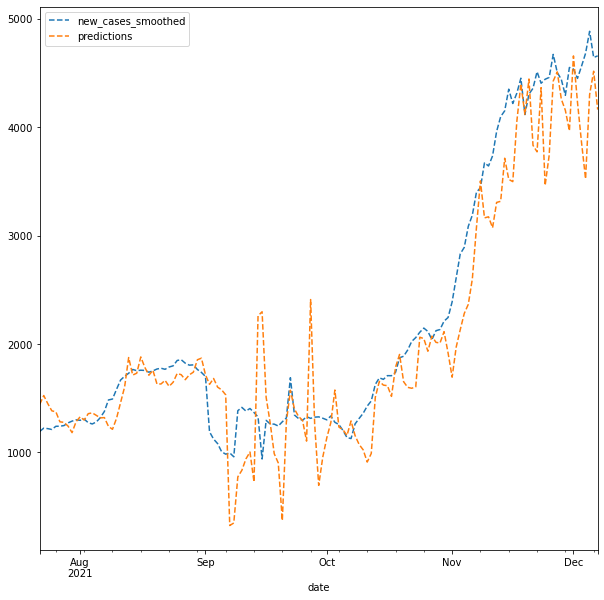

In [45]:
y_test.reset_index(inplace=True)
y_test.plot(x='date', y=['new_cases_smoothed','predictions'], linestyle="dashed", figsize=(10,10))


In [46]:

y_val['predictions'] = y_val_pred.tolist()

In [47]:
y_val.reset_index(inplace=True)

<AxesSubplot:xlabel='date'>

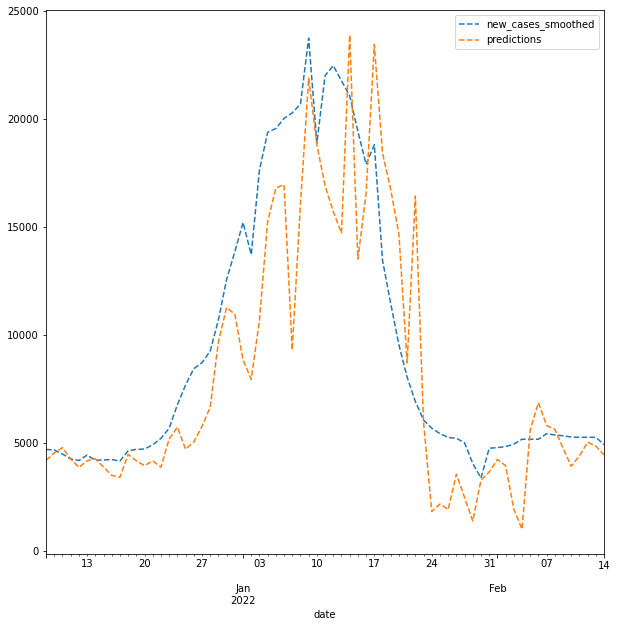

In [48]:
y_val.plot(x='date', y=['new_cases_smoothed', 'predictions'], linestyle="dashed", figsize=(10,10))

In [49]:
data.tail(25)

,new_cases_smoothed,covid: (Ireland)
date,,
2022-01-21,8052.429,21.0
2022-01-22,6928.714,21.0
2022-01-23,6068.429,21.0
2022-01-24,5691.714,19.0
2022-01-25,5440.143,19.0
2022-01-26,5263.286,19.0
2022-01-27,5226.429,19.0
2022-01-28,5013.857,19.0
2022-01-29,4058.286,19.0


In [50]:
owid = pd.read_csv("owid-covid-data(1).csv")

In [51]:
trend = pd.read_csv("multiTimeline(4).csv", skiprows=2)

In [52]:
owid.tail()

,date,new_cases_smoothed
739,09/03/2022,3083.143
740,10/03/2022,3085.143
741,11/03/2022,3818.000
742,12/03/2022,NaN
743,13/03/2022,NaN


In [53]:
trend.head()

,Day,COVID: (Ireland)
0,14/12/2021,37
1,15/12/2021,41
2,16/12/2021,46
3,17/12/2021,53
4,18/12/2021,46


In [54]:
combi = pd.merge(owid, trend, left_on='date', right_on='Day', how='left')

In [55]:
combi['new_cases_smoothed'].fillna(method='ffill', inplace=True)

In [56]:
combi.tail()

,date,new_cases_smoothed,Day,COVID: (Ireland)
739,09/03/2022,3083.143,09/03/2022,17.0
740,10/03/2022,3085.143,10/03/2022,19.0
741,11/03/2022,3818.000,11/03/2022,19.0
742,12/03/2022,3818.000,12/03/2022,0.0
743,13/03/2022,3818.000,NaN,NaN


In [57]:
combi.drop(columns=['Day'], inplace=True)

In [58]:
combi.loc[:,'ncs'] = combi.loc[:,'new_cases_smoothed'].shift(5)
combi.loc[:,'ncs_diff'] = combi.loc[:,'ncs'].diff()
combi.loc[:,'ncs2'] = combi.loc[:,'ncs'].shift()
combi.loc[:,'ncs_diff2'] = combi.loc[:,'ncs2'].diff()
combi.loc[:,'ncs3'] = combi.loc[:,'ncs2'].shift()
combi.loc[:,'ncs_diff3'] = combi.loc[:,'ncs3'].diff()
combi.loc[:,'ncs4'] = combi.loc[:,'ncs3'].shift()
combi.loc[:,'ncs_diff4'] = combi.loc[:,'ncs4'].diff()
combi.loc[:,'ncs5'] = combi.loc[:,'ncs4'].shift()
combi.loc[:,'ncs_diff5'] = combi.loc[:,'ncs5'].diff()
combi.loc[:,'ncs6'] = combi.loc[:,'ncs5'].shift()
combi.loc[:,'ncs_diff6'] = combi.loc[:,'ncs6'].diff()
combi.loc[:,'ncs7'] = combi.loc[:,'ncs6'].shift()
combi.loc[:,'ncs_diff7'] = combi.loc[:,'ncs7'].diff()

In [59]:
combi.loc[:,'google'] = combi.loc[:,'COVID: (Ireland)'].shift(5)
combi.loc[:,'google_diff'] = combi.loc[:,'google'].diff()
combi.loc[:,'google2'] = combi.loc[:,'google'].shift()
combi.loc[:,'google_diff2'] = combi.loc[:,'google2'].diff()
combi.loc[:,'google3'] = combi.loc[:,'google2'].shift()
combi.loc[:,'google_diff3'] = combi.loc[:,'google3'].diff()
combi.loc[:,'google4'] = combi.loc[:,'google3'].shift()
combi.loc[:,'google_diff4'] = combi.loc[:,'google4'].diff()
combi.loc[:,'google5'] = combi.loc[:,'google4'].shift()
combi.loc[:,'google_diff5'] = combi.loc[:,'google5'].diff()
combi.loc[:,'google6'] = combi.loc[:,'google5'].shift()
combi.loc[:,'google_diff6'] = combi.loc[:,'google6'].diff()
combi.loc[:,'google7'] = combi.loc[:,'google6'].shift()
combi.loc[:,'google_diff7'] = combi.loc[:,'google7'].diff()

In [60]:
combi.head()

,date,new_cases_smoothed,COVID: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
0,29/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/03/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02/03/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,03/03/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,04/03/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
combi.tail(30)

,date,new_cases_smoothed,COVID: (Ireland),ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
714,12/02/2022,5270.286,14.0,5439.143,257.857,5181.286,0.000,5181.286,0.000,5181.286,...,17.0,0.0,17.0,-4.0,21.0,-1.0,22.0,0.0,22.0,-1.0
715,13/02/2022,5270.286,17.0,5378.000,-61.143,5439.143,257.857,5181.286,0.000,5181.286,...,18.0,1.0,17.0,0.0,17.0,-4.0,21.0,-1.0,22.0,0.0
716,14/02/2022,4927.000,18.0,5340.429,-37.571,5378.000,-61.143,5439.143,257.857,5181.286,...,19.0,1.0,18.0,1.0,17.0,0.0,17.0,-4.0,21.0,-1.0
717,15/02/2022,4927.000,19.0,5281.571,-58.858,5340.429,-37.571,5378.000,-61.143,5439.143,...,20.0,1.0,19.0,1.0,18.0,1.0,17.0,0.0,17.0,-4.0
718,16/02/2022,4927.000,17.0,5270.286,-11.285,5281.571,-58.858,5340.429,-37.571,5378.000,...,19.0,-1.0,20.0,1.0,19.0,1.0,18.0,1.0,17.0,0.0
719,17/02/2022,4927.000,16.0,5270.286,0.000,5270.286,-11.285,5281.571,-58.858,5340.429,...,18.0,-1.0,19.0,-1.0,20.0,1.0,19.0,1.0,18.0,1.0
720,18/02/2022,4927.000,15.0,5270.286,0.000,5270.286,0.000,5270.286,-11.285,5281.571,...,16.0,-2.0,18.0,-1.0,19.0,-1.0,20.0,1.0,19.0,1.0
721,19/02/2022,4927.000,14.0,4927.000,-343.286,5270.286,0.000,5270.286,0.000,5270.286,...,14.0,-2.0,16.0,-2.0,18.0,-1.0,19.0,-1.0,20.0,1.0
722,20/02/2022,4927.000,15.0,4927.000,0.000,4927.000,-343.286,5270.286,0.000,5270.286,...,17.0,3.0,14.0,-2.0,16.0,-2.0,18.0,-1.0,19.0,-1.0
723,21/02/2022,4927.000,15.0,4927.000,0.000,4927.000,0.000,4927.000,-343.286,5270.286,...,18.0,1.0,17.0,3.0,14.0,-2.0,16.0,-2.0,18.0,-1.0


In [62]:
combi['date'] = pd.to_datetime(combi['date'])

In [63]:
dates = combi.iloc[729:743,0]

In [64]:
x_combi_slice = combi.iloc[717:731,:]

In [65]:
x_combi_slice.drop(columns=['new_cases_smoothed','COVID: (Ireland)'], inplace=True)

In [66]:
x_combi_slice.set_index('date', inplace=True)

In [67]:
x_combi_slice

,ncs,ncs_diff,ncs2,ncs_diff2,ncs3,ncs_diff3,ncs4,ncs_diff4,ncs5,ncs_diff5,...,google3,google_diff3,google4,google_diff4,google5,google_diff5,google6,google_diff6,google7,google_diff7
date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,5281.571,-58.858,5340.429,-37.571,5378.000,-61.143,5439.143,257.857,5181.286,0.000,...,20.0,1.0,19.0,1.0,18.0,1.0,17.0,0.0,17.0,-4.0
2022-02-16,5270.286,-11.285,5281.571,-58.858,5340.429,-37.571,5378.000,-61.143,5439.143,257.857,...,19.0,-1.0,20.0,1.0,19.0,1.0,18.0,1.0,17.0,0.0
2022-02-17,5270.286,0.000,5270.286,-11.285,5281.571,-58.858,5340.429,-37.571,5378.000,-61.143,...,18.0,-1.0,19.0,-1.0,20.0,1.0,19.0,1.0,18.0,1.0
2022-02-18,5270.286,0.000,5270.286,0.000,5270.286,-11.285,5281.571,-58.858,5340.429,-37.571,...,16.0,-2.0,18.0,-1.0,19.0,-1.0,20.0,1.0,19.0,1.0
2022-02-19,4927.000,-343.286,5270.286,0.000,5270.286,0.000,5270.286,-11.285,5281.571,-58.858,...,14.0,-2.0,16.0,-2.0,18.0,-1.0,19.0,-1.0,20.0,1.0
2022-02-20,4927.000,0.000,4927.000,-343.286,5270.286,0.000,5270.286,0.000,5270.286,-11.285,...,17.0,3.0,14.0,-2.0,16.0,-2.0,18.0,-1.0,19.0,-1.0
2022-02-21,4927.000,0.000,4927.000,0.000,4927.000,-343.286,5270.286,0.000,5270.286,0.000,...,18.0,1.0,17.0,3.0,14.0,-2.0,16.0,-2.0,18.0,-1.0
2022-02-22,4927.000,0.000,4927.000,0.000,4927.000,0.000,4927.000,-343.286,5270.286,0.000,...,19.0,1.0,18.0,1.0,17.0,3.0,14.0,-2.0,16.0,-2.0
2022-02-23,4927.000,0.000,4927.000,0.000,4927.000,0.000,4927.000,0.000,4927.000,-343.286,...,17.0,-2.0,19.0,1.0,18.0,1.0,17.0,3.0,14.0,-2.0


In [68]:
x_combi_slice.fillna(method='ffill', inplace=True)

In [69]:
y_combi_slice = combi.iloc[729:743,1]

In [70]:
y_combi_slice.shape

(14,)

In [71]:
y_combi_slice = y_combi_slice.to_frame()


In [72]:
y_combi_slice_pred = best_model.predict(x_combi_slice)

In [73]:
print(r2_score(y_combi_slice, y_combi_slice_pred))

-17.92132614669942


In [74]:
y_combi_slice['predictions'] = y_combi_slice_pred.tolist()

In [75]:
y_combi_slice['dates'] = dates.tolist()

<AxesSubplot:xlabel='dates'>

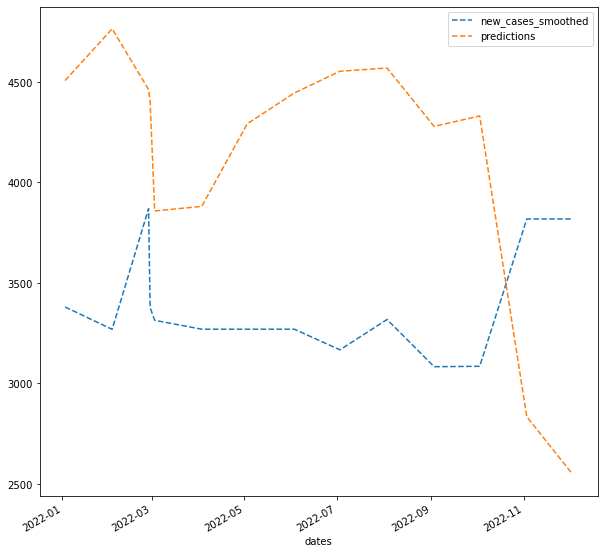

In [76]:
y_combi_slice.reset_index(inplace=True)
y_combi_slice.plot(x='dates', y=['new_cases_smoothed','predictions'], linestyle="dashed", figsize=(10,10))